In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.4.1 cuda: True


In [2]:
## Load dataset
data_path = "../../../rings_fixed_radius"
Data = torch.from_numpy(np.load(data_path + '/obs.npy')).float()
FIXED_RADIUS = 1.5

NUM_DATASETS, N, D = Data.shape
K = 5 ## number of clusters
SAMPLE_SIZE = 10
NUM_HIDDEN_GLOBAL = 32
NUM_HIDDEN_LOCAL = 64
NUM_STATS = 16

MCMC_SIZE = 10
BATCH_SIZE = 20
NUM_EPOCHS = 500
LEARNING_RATE = 1e-4

CUDA = torch.cuda.is_available()
PATH = 'AG-5rings-%dsteps-%dsamples' % (MCMC_SIZE, SAMPLE_SIZE)
DEVICE = torch.device('cuda:1')

obs_rad = torch.ones(1) * FIXED_RADIUS
noise_sigma = torch.ones(1) * 0.05
if CUDA:
    obs_rad = obs_rad.cuda().to(DEVICE)
    noise_sigma = noise_sigma.cuda().to(DEVICE)
Train_Params = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE, CUDA, DEVICE, PATH)
Model_Params = (obs_rad, noise_sigma, N, K, D, MCMC_SIZE)

In [3]:
from local_enc_mu import *
from global_oneshot_mu import *
from global_enc_mu_v1 import *
## if reparameterize continuous variables
Reparameterized = False
# initialization
enc_z = Enc_z(K, D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)
enc_mu = Enc_mu(K, D, NUM_HIDDEN_GLOBAL, NUM_STATS, CUDA, DEVICE, Reparameterized)
oneshot_mu = Oneshot_mu(K, D, NUM_HIDDEN_GLOBAL, NUM_STATS, CUDA, DEVICE, Reparameterized)
if CUDA:
    enc_z.cuda().to(DEVICE)
    enc_mu.cuda().to(DEVICE)
    oneshot_mu.cuda().to(DEVICE)
optimizer =  torch.optim.Adam(list(oneshot_mu.parameters())+list(enc_mu.parameters())+list(enc_z.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
models = (oneshot_mu, enc_mu, enc_z)

In [4]:
enc_z.load_state_dict(torch.load("../weights/enc-z-%s" % PATH))
enc_mu.load_state_dict(torch.load("../weights/enc-mu-%s" % PATH))
oneshot_mu.load_state_dict(torch.load("../weights/oneshot-mu-%s" % PATH))

In [5]:
from ag_ep import *
# train(models, EUBO_fixed_radi, optimizer, Data, Model_Params, Train_Params)

In [6]:
# torch.save(enc_z.state_dict(), "../weights/enc-z-%s" % PATH)
# torch.save(enc_mu.state_dict(), "../weights/enc-mu-%s" % PATH)
# torch.save(oneshot_mu.state_dict(), "../weights/oneshot-mu-%s" % PATH)

In [7]:
from ag_ep import *
BATCH_SIZE_TEST = 50
Train_Params_Test = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE_TEST, CUDA, DEVICE, PATH)

obs, metric_step, reused = test(models, EUBO_fixed_radi, Data, Model_Params, Train_Params_Test)
(q_mu, _, q_z, _) = reused

CPU times: user 5.22 s, sys: 68.6 ms, total: 5.29 s
Wall time: 5.29 s


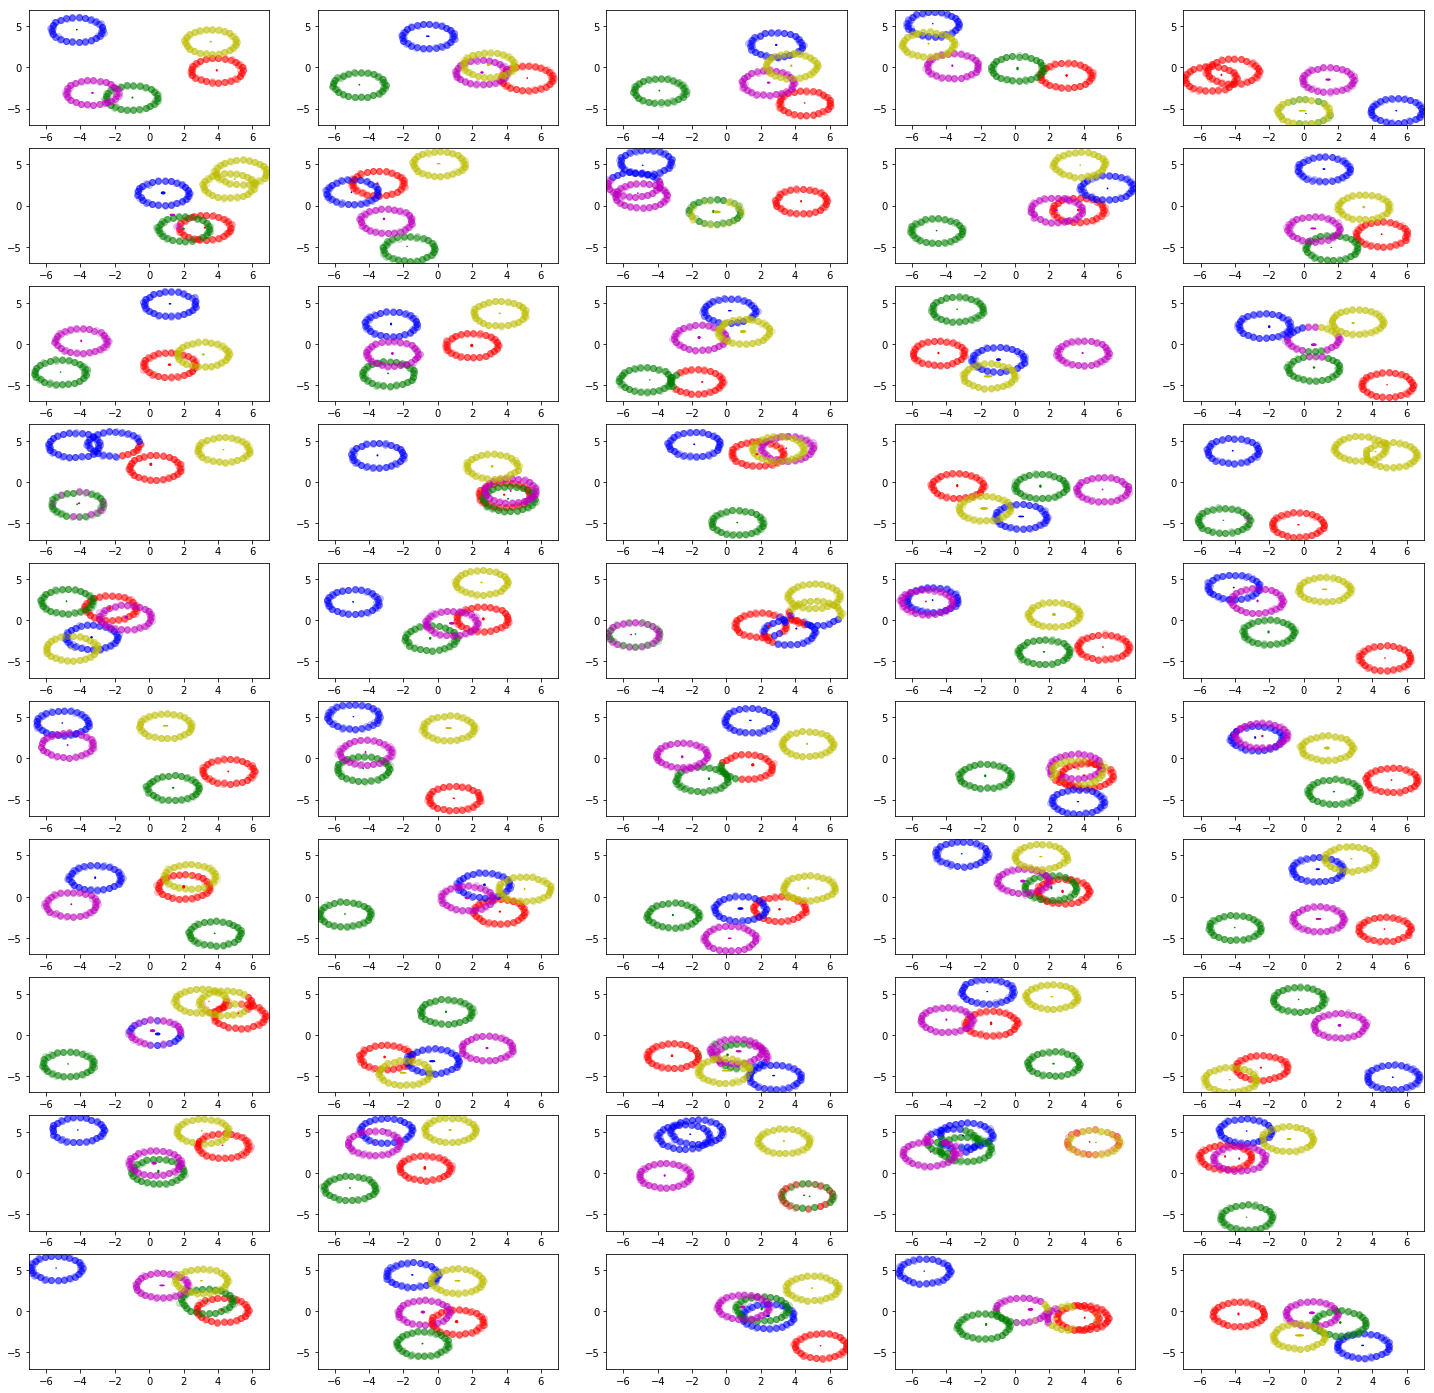

In [8]:
%time plot_samples(obs, q_mu, q_z, K, PATH)